How can the European bank identify and predict key factors driving customer churn, and what strategies can be implemented to reduce churn based on customer profiles and behavior patterns?

# Imports, Data and Functions

In [1]:
# IMPORTS 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from tabulate import tabulate

In [2]:
# LOADING THE DATA 
df = pd.read_csv('churn_bank.csv')

NRows, NColumns = df.shape
columnNames = list(df.columns)

# Creating two additional datasets for future comparison
dfStayed = df.loc[df['Exited']==0]
dfExited = df.loc[df['Exited']==1]

In [66]:
#####
# List of functions - used in our code to plot charts (several chart type are used multiple times, we therefore avoid duplicates of big paragraphs of code by using functions)
# We faced issues with VS CODE to import the functions from another file, which would have been ideal, so we kept them in the main file
#####

# DENSITY CHART (x and hue)
def plot_density(data, x_col, hue_col=None, fill=True, title=None, xlabel=None, ylabel='Density'):
    """
    Generates a density plot for a given dataset.

    Parameters (those are the inputs you have to enter in your main code):
    - data: the dataset to plot
    - x_col: the column to plot the density for
    - hue_col: the column to group data by different categories (e.g., 'Geography')
    - fill: whether to fill the area under the curve (default: True)
    - title: the title of the plot
    - xlabel: the label for the x-axis
    - ylabel: str, optional, the label for the y-axis (default: 'Density')
    """

    sns.kdeplot(data=data, x=x_col, hue=hue_col, fill=fill)
    
    # Set plot title and labels
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(x_col)
    plt.ylabel(ylabel)
    

    plt.show()

##### 
# SINGLE DENSITY CHART (x only)
def plot_kde_and_summary(df, column, title):
    # Create the KDE plot
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.kdeplot(
        x=df[column]
    )
    ax.set(
        title=title,
        xlabel=column,
        ylabel="Density"
    )
    plt.show()


#####
# STACKED BAR CHART - INTERACTION OF VARIABLES
def plot_stacked_bar(df, group_col, category_col, title, normalize=False):
    # Group and normalize values to get proportions in percentage
    df_grouped = (
        df.groupby(group_col)[category_col]
        .value_counts(normalize) ## to have proportions instead of absolute values use normalize=True
        .mul(100)
        .round(2)
        .unstack()
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    # Plot each category as a bar
    bottom = None
    for category in df_grouped.columns:
        ax.bar(
            df_grouped.index,
            df_grouped[category],
            label=category,
            width=0.3,
            bottom=bottom
        )
        # Update bottom for stacking
        bottom = df_grouped[category] if bottom is None else bottom + df_grouped[category]

    ax.set(
        title=title,
        xlabel="",
        ylabel="Proportion (%)",
    )
    ax.legend(title=category_col)
    plt.show()

#####
# REGULAR BAR CHART - ONE VARIABLE TO PLOT 
def plot_bar_single(df, category_col, title, colors, normalize=False):

    category_counts = df[category_col].value_counts(normalize)  ## to have proportions instead of absolute values use normalize=True

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        palette=sns.color_palette(colors)
    )

    sns.set_theme(style="darkgrid")
    ax.set(
        title=title,
        xlabel=category_col,
        ylabel="Proportion"
    )
    
    sns.set_theme(style="darkgrid")
    plt.show()


# Correlation Analysis 

### Calculating the differences in summary statistics

In [4]:
## calculating the differences in summary statistics
columnNamesDescribe = list(df.columns.drop(['Surname', 'Geography', 'Gender']))
columns2keep = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
columns2Drop = [val for val in columnNamesDescribe if val not in columns2keep]

differences_in_trends = np.array(dfExited.describe().T.drop(columns2Drop)) - np.array(dfStayed.describe().T.drop(columns2Drop))
# #differences_in_trends = (np.array(dfExited.describe().T.drop(columns2Drop)) - np.array(dfStayed.describe().T.drop(columns2Drop)))/np.array(dfStayed.describe().T.drop(columns2Drop))
# #len(columnNames)-len(differences_in_trends)
differences_in_trends = pd.DataFrame(differences_in_trends).set_index(pd.Index(columns2keep))

headers=['variable', 'count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
table = [pd.DataFrame(columns2keep), pd.DataFrame(differences_in_trends)]
print(tabulate(differences_in_trends, headers))

variable           count          mean            std     min       25%      50%      75%       max
---------------  -------  ------------  -------------  ------  --------  -------  -------  --------
CreditScore        -5926     -6.5017        4.66767    -55        -7        -7      -2         0
Age                -5926      7.42961      -0.363801     0         7         9      10        -8
Tenure             -5926     -0.100535      0.0554485    0        -1         0       1         0
Balance            -5926  18363.2       -4487.25         0     38340     17276.6  5023.05  29365.3
EstimatedSalary    -5926   1727.29        506.831      -78.49   1124.23   2815.8  3812.95   -184.38


* Credit Score: no big difference between exited and stayed, except that it seems the min value of those who exited is higher.
* Age: those who exit are on average 7 years younger.
* tenure: Those who exit seem to have been clients of the bank for a bit longer, but not a significative amount of time in average.
* Balance: Those who exit seem to have a smaller average balance (of almost 19000).
* EstmatedSalary: those who exit have a slightly smaller salary but nothing huge/significative.

### Making dictionaries for the general descriptions

In [5]:
# creating a dictionary for all types
types_df = df.dtypes.to_frame(name="type")

types = {}
for i in range(0, 13):
    types[columnNames[i]] = types_df.iloc[i, 0].type

In [6]:
# creating a dictionary for all mins, means, maxs, ...
df_describe = df.describe().T

mins_df = df_describe.loc[:,"min"]
maxs_df = df_describe.loc[:,"max"]
means_df = df_describe.loc[:,"mean"]
median_df = df_describe.loc[:,"50%"]
std_df = df_describe.loc[:,"std"]

mins = {}
means = {}
maxs = {}
medians = {}
stds = {}

for i in range(len(df_describe)):
    key = columnNamesDescribe[i]
    mins[key] = mins_df.iloc[i]
    maxs[key] = maxs_df.iloc[i]
    means[key] = means_df.iloc[i]
    medians[key] = median_df.iloc[i]
    stds[key] = std_df.iloc[i]

### Correlation Matrix

[Text(0.5, 1.0, 'Overview: Correlation matrix')]

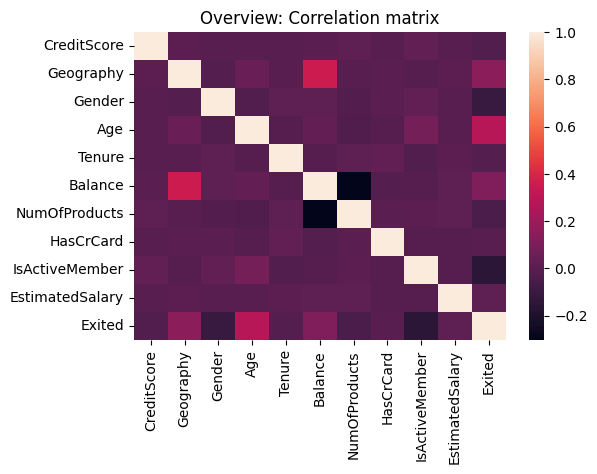

In [7]:
# The correlation matrix function only takes numerical values not string. 
# Therefore we transform the Geography and Gender as numerical values (dummies).
COUNTRY = {"France":"1",
        "Spain":"2",
        "Germany":"3"}
GENDER = {"Female":"1",
        "Male":"2"}

df_corr = df.copy()
df_corr.replace({'Geography': COUNTRY, 'Gender': GENDER}, inplace=True) 

df_corr = df_corr.drop(columns=["Surname", "CustomerId"])
# computing it
matrix_corr = df_corr.corr()
# plotting
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix_corr)
# title and axis labels
ax.set(
    title="Overview: Correlation matrix"
)

Strongest correlation

- Geography - Exited. 
- Age - Exited. 
- Balance - Exited 
   
Not directly correlated to churn but studied in the first part: 

- Balance - Geography  
- Nbr of products - Exited (very little)
- Age - Is active member (very little) 

# General Analysis

### INDIVIDUAL DISTRIBUTION OF VARIABLES 

To try to identify the main factors contributing to customer churn we will first proceed by making a general review of the variables we are working with, their distributions and trends. This will give us more perspective over the dataset, which will allow us to decide how to treat this database to find the causes of churn amongst the bank's clients and to interpret the results. 

The dataset is composed of the following variables: our categorical variables are Geography, Gender, HasCrCard, IsActiveMember, Exited; and the quantitative variables are CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary. The variables CustomerId and Surname act as indexes and references to every client but are not relevant to our analysis. 

We will first focus into an exploratory analysis of the variable's individual distributions, section in which we will also introduce and explain each of the variables for a general overview.


We have divided variables into three categories: those indicative of a customer's identity, those pertaining to each customers' finacial information, and finally those relating to a customer's "activity" or behavior with respect to the bank and its products. The former group will help us build a customer profile non relative to their financial situation, which we will afterwards complement with financial information, and analyse if this complete profil is related to the customer's activity status, and more importantly to churn.

### Customer profile: Gender, Age and Geography

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/4053250320.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


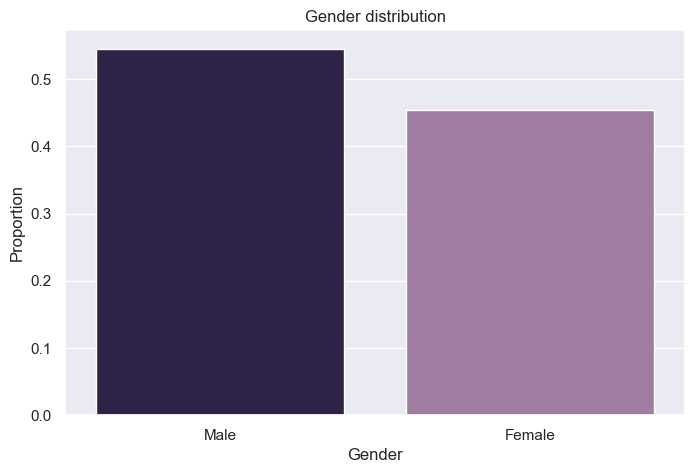

In [67]:
# GENDER 
# Gender is a binary categorical variable that can take 2 values: Male or Female. 

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="Gender",
    title="Gender distribution",
    colors=["#2c1c4d", "#a577a6"], 
    normalize=True
)

The bank has 4543 female clients (45.43% of the total) and 5457 male clients (54.57%)

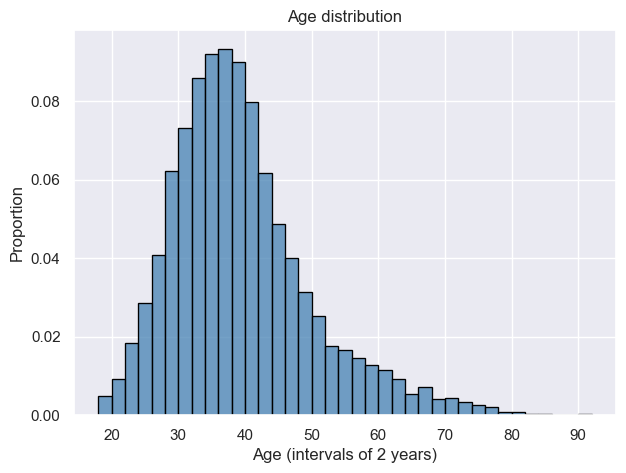

The bank's clients are between 18 and 92 years old, with the median age being 37.0 and a standard deviation of 10.49 years.


In [9]:
# AGE 

fig, ax = plt.subplots(figsize=[7, 5])

sns.histplot(
    x = df["Age"],
    stat='probability',
    binwidth = 2,
    color="steelblue",
    edgecolor = "black",
)

ax.set(
    title = "Age distribution",
    xlabel = "Age (intervals of 2 years)",
    ylabel = "Proportion"
)
sns.set_theme(style="darkgrid")
plt.show()

message = "The bank's clients are between {} and {} years old, with the median age being {} and a standard deviation of {} years.".format(
    int(mins["Age"]), int(maxs["Age"]),
    round(medians["Age"], 2), round(stds["Age"], 2)
)
print(message)

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(


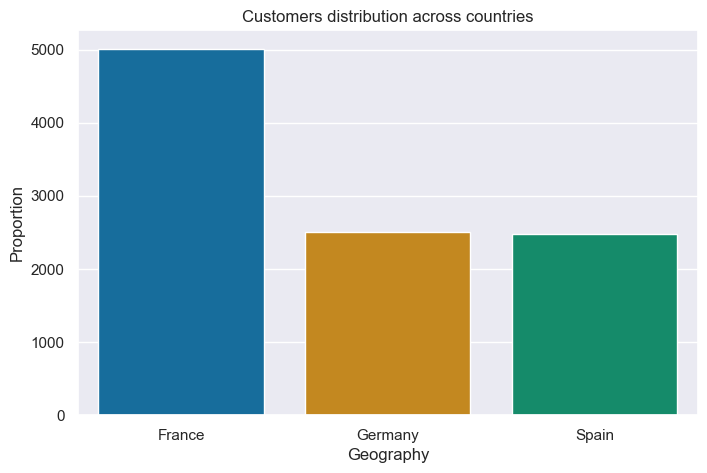

In [10]:
# GEOGRAPHY 

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="Geography",
    title="Customers distribution across countries",
    colors="colorblind"
)

The bank's clients are majoritarily from France (50.14 percent), followed closely by Germany and Spain (25.09 and 24.77 percent of the total respectively).

The results lead us to speculate that the bank might be Frenchin origin, and later expanded to offer its services in Germany and Spain, since the number of customers in these two countries is much slower. Additionally, the bank might be facing some competition in the German and Spanish markets. 

It is interesting to see if the age profile in customers in each country provides insight into our theory. For example, a younger age distribution in Germany and Spain than in France could indicate a higher penetration of the bank's services in the two branches amongst young customers who do not have an established bank acocunt yet. However, we do not observe any major differences in age distribution in the three countries. 

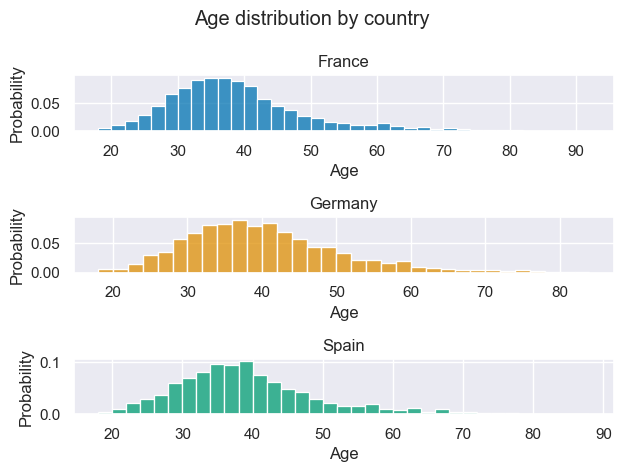

In [11]:
# AGE AND GEOGRAPHY

fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(country)

    this_df = df[df["Geography"] == country]

    sns.histplot(
        x = this_df["Age"],
        stat='probability',
        color=sns.color_palette("colorblind")[i],
        binwidth = 2,
        ax=ax[i]
    )

sns.set_theme(style="darkgrid")
fig.suptitle('Age distribution by country')
fig.tight_layout()
plt.show()

### Customer Description: Financial Analysis

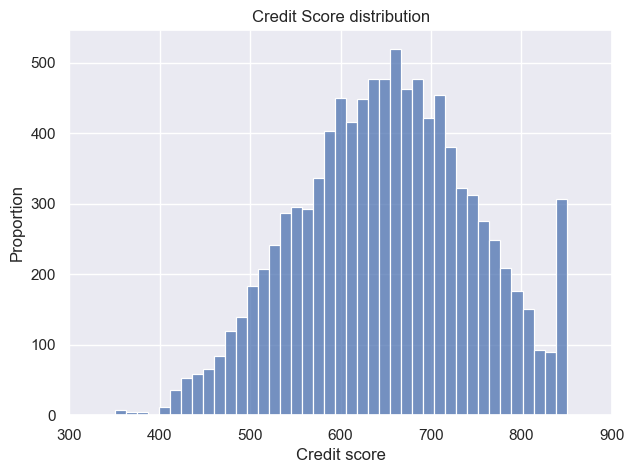

The average credit score is around 650.5288, with a standard deviation of 96.65 points.
We observe an interesting peak in the proportion of people who have a credit score around 850.


In [12]:
# CREDIT SCORE 
# Credit score is a number from 300 to 850 that rates a consumer's creditworthiness. 
# It represents a customer's credit history and your ability to pay your loans and financial obligations. 
# In particular, the FICO score divides credit score into different intervals to simplify the interpretation of the score according to each customer. 

fig, ax = plt.subplots(figsize=[7, 5])

sns.histplot(
    x = df["CreditScore"]
)
plt.xlim([300, 900]) 

ax.set(
    title = "Credit Score distribution",
    xlabel = "Credit score",
    ylabel = "Proportion"
)
plt.show()

message = "The average credit score is around {}, with a standard deviation of {} points.\nWe observe an interesting peak in the proportion of people who have a credit score around 850.".format(
    means["CreditScore"],
    round(stds["CreditScore"], 2)
)
print(message)

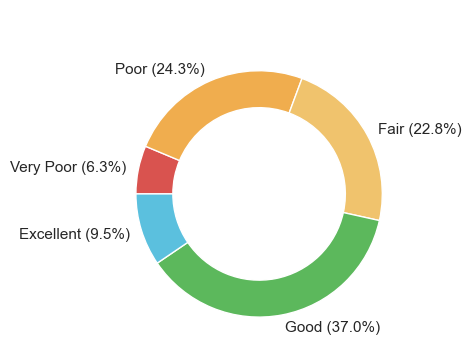

In [13]:
# CATEGORICAL CREDIT SCORE

df["CreditScore"].unique()
df["CreditScore"].min()
df["CreditScore"].max()
# in our data [350 - 850]

# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df['Credit_Category'] = df['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles 
proportions = category_counts.values
angles = proportions * 180  

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()


Most clients' credit scores in this bank between 'poor' and 'fair', with 'good' being the most common and very few scoring 'excellent' or 'very poor' credit.


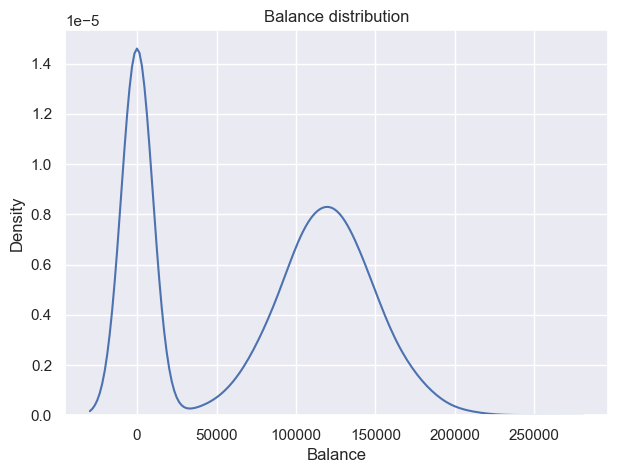

In [14]:
# BALANCE 

plot_kde_and_summary(df, "Balance", title="Balance distribution")


The average balance is of 76485.89€ and the median is of 97198.54€. This is because the proportion of people whose balance is at 0 is considerable: 36.17 percent.


In [15]:
print(f"The percentage of people in the bank with a 0 balance is {100*len(df[df['Balance'] == 0])/NRows}.")

The percentage of people in the bank with a 0 balance is 36.17.


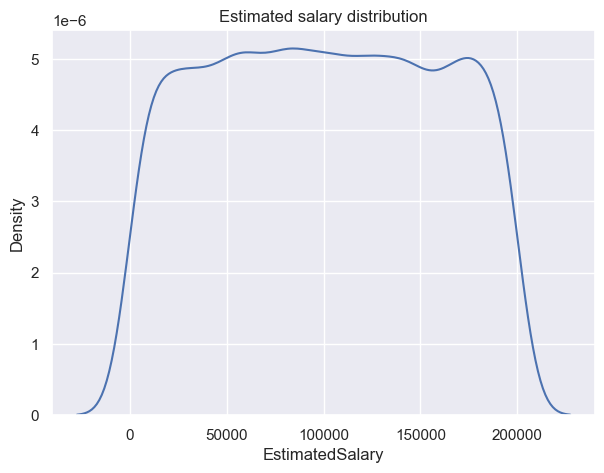

In [16]:
# ESTIMATED SALARY

plot_kde_and_summary(df, "EstimatedSalary", title="Estimated salary distribution")


The average estimated salary is of 100090.24€ and the median is of 100193.92€.
It is interesting to note that we observe a very uniform distribution across all values, with a slight peak at the end of the distribution.

People all over the distribution of salary seem to be clients of this bank. However, it is very interesting to note the disparity between this result and the very skewed distribution in balance. 

If we group people having a very low balance, around zero, and those having a higher balance, we do not actually see any difference in the estimated salary distributions of the two groups. This implies that there seems to be an important element outside of estimated salary that will affect balance and which we fail to observe.

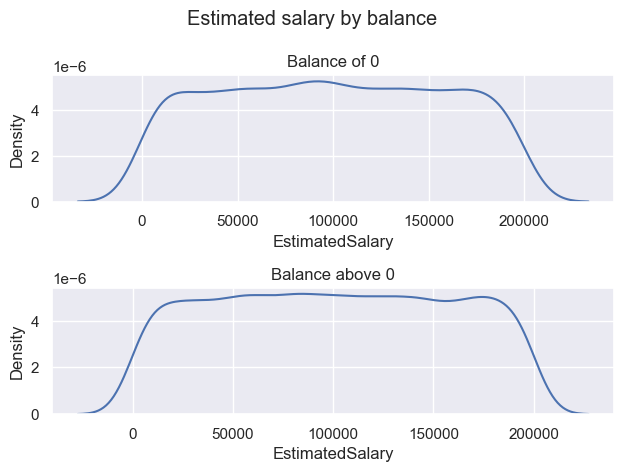

In [17]:
# ESTIMATED SALARY AND BALANCE 

balance_differences = [df[df['Balance'] == 0], df[df['Balance'] != 50000]]
balance_types = ["Balance of 0", "Balance above 0"]

fig, ax = plt.subplots(2, 1)
for i in range(2):
     
    dataframe = balance_differences[i]

    ax[i].set_title(balance_types[i])
    sns.kdeplot(
    x = dataframe["EstimatedSalary"],ax=ax[i]
)

sns.set_theme(style="darkgrid")
fig.suptitle('Estimated salary by balance')
fig.tight_layout()
plt.show()

In summary, the financial analysis of our customers show us 3 main things. One, that the customers' credit score seems to evenly spread out around what is consider as a "fair" average credit score, with a peak in numbers of people with excellent credit scores. Two, that estimated salary is very evenly distributed amongst the banks customers. Three, that balance shows a highly skewed distribution, with 36.17 of people having a balance of 0. 

### Customer Description: Activity

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


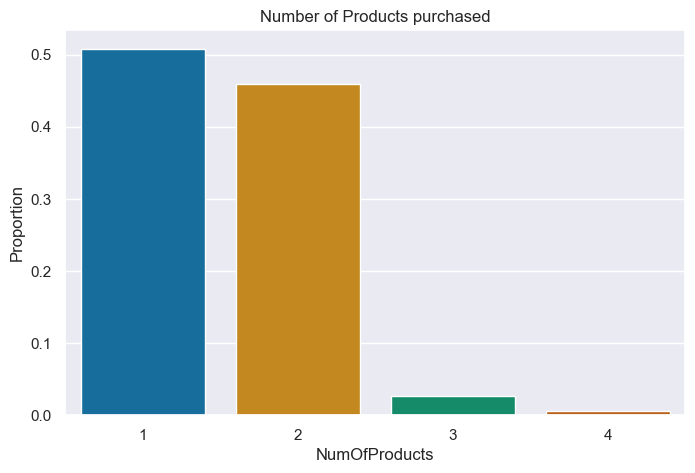

In [18]:
# NUMBER OF BANK PRODUCTS PURCHASED BY THE CUSTOMER 

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="NumOfProducts",
    title="Number of Products purchased",
    colors="colorblind",
    normalize=True
)

Observing the number of products the customer contracted with the bank, we can see customers have bought at least 1 product.
This product might need to be necessary to be classified as a bank cutsomer because no customer has bought no products.
This product could tus be a bank account. 
Almost half have bought 2, and under 5 percent have bought more.
However, we have to be careful when comparing all groups amongst eachother,
since the sizes of people having purchased 3 and 4 products are too small: 
266 and 60 compared to 5084 and 4590 for 1 and 2 prodcts purchased respectively.

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


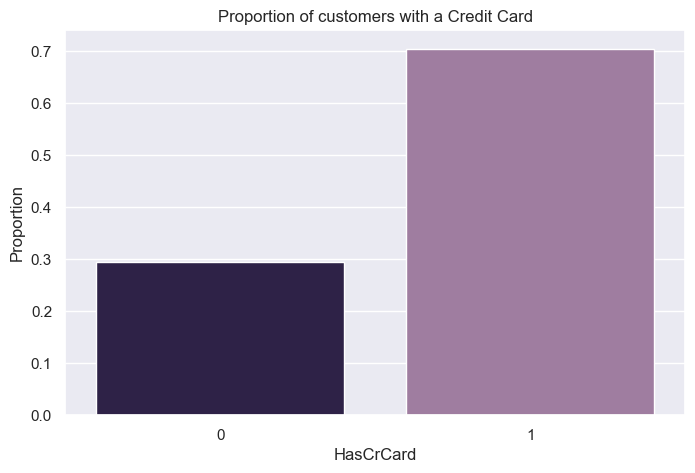

In [19]:
# HAVING A CREDIT CARD 

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="HasCrCard",
    title="Proportion of customers with a Credit Card",
    colors=["#2c1c4d", "#a577a6"],
    normalize=True
)

We observe that 70% of the bank's customers have a credit card. 

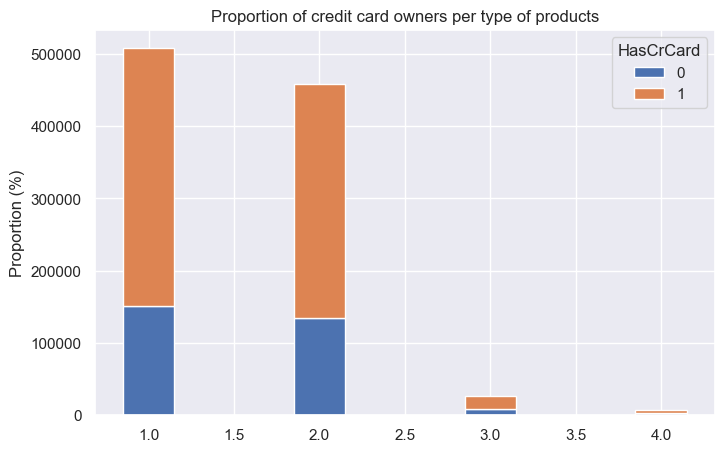

In [20]:
# HYPOTHESIS TEST : IS "product 2" a credit card, and "product 1" the bank account itself? 

# Using our plot_stacked_bar function adjusting for the inputs
plot_stacked_bar(df, "NumOfProducts", "HasCrCard", "Proportion of credit card owners per type of products", normalize=False)

However, we also observe that not all people who have purchased two products have a credit card, so a credit card cannot be the second product.

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


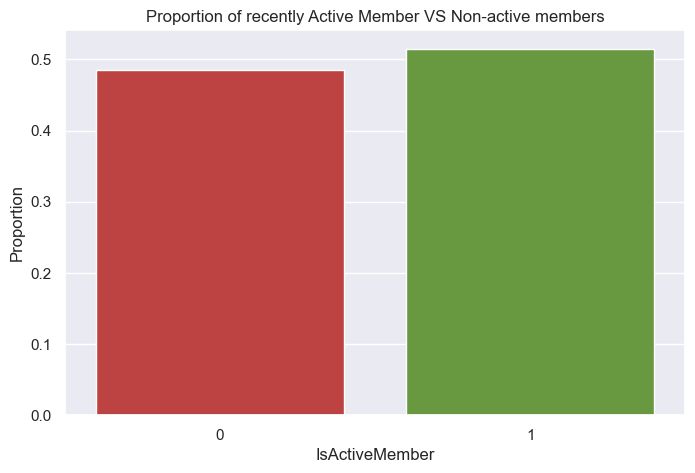

In [21]:
# BEING AN ACTIVE MEMBER 
# The bank defines an active customer as someone that has been recently active, for example who has made transactions, as oposed to those who haven't. 
# The definition of how we measure "recently" as well as activity is not very detailed. 

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="IsActiveMember",
    title="Proportion of recently Active Member VS Non-active members",
    colors=["#d12f2c","#66a832"],
    normalize=True
)

We observe that the proportions of active and non active members are almost (worriyngly?) equal, as almost 50% of the customers have not been recently active, but it is hard to interpret the implications as we lack the details of the definition. 

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


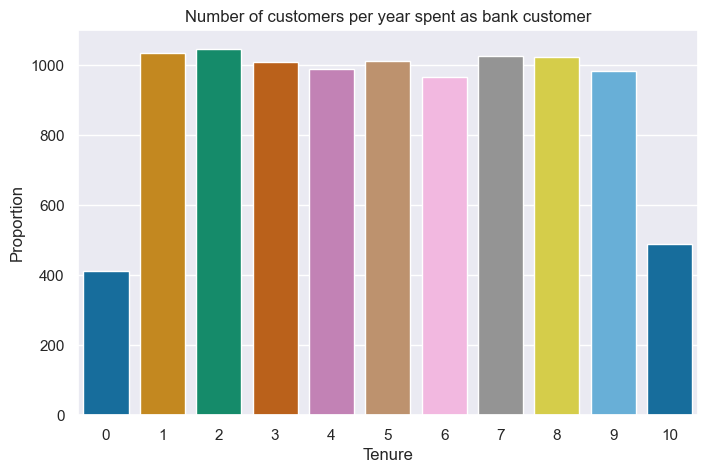

In [22]:
# TENURE 
# Tenure is the number of years the customer has been a client of the bank.

# Using our plot_bar_single function adjusting for the inputs
plot_bar_single(
    df=df,
    category_col="Tenure",
    title="Number of customers per year spent as bank customer",
    colors="colorblind",
    normalize=False
)

 We can see a very even distribution of the amount of years the banks' customers have been their client for, with the exception of people who have been with the bank for ten years, which is a smaller sample.

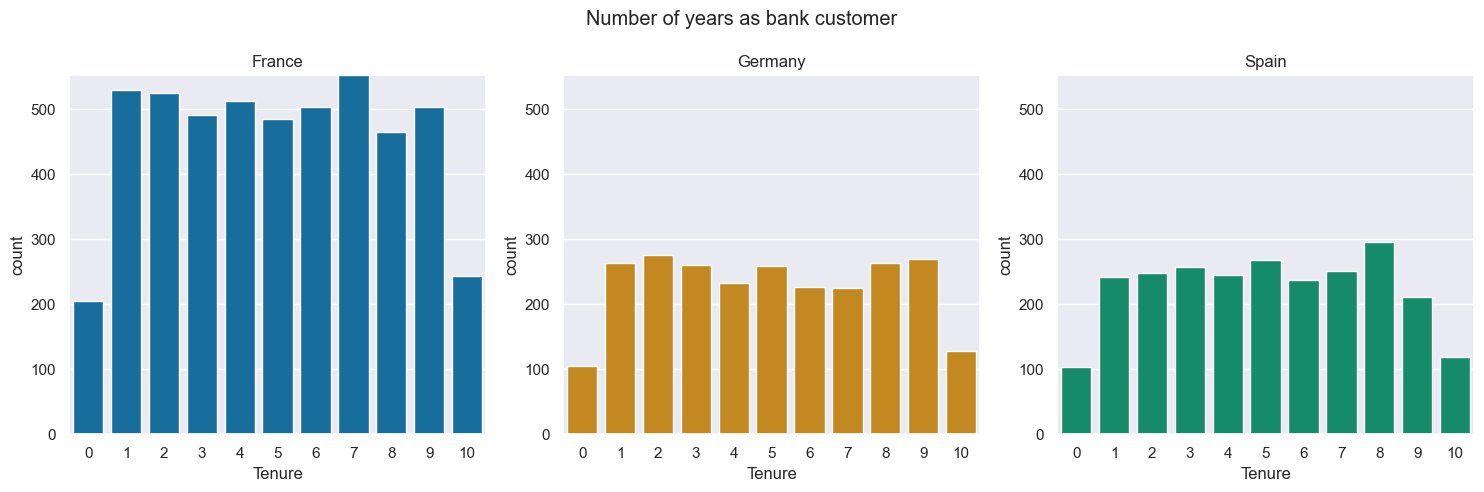

In [23]:
# TENURE AND GEOGRAPHY

country_differences = [df[df['Geography'] == "France"], df[df['Geography'] == "Germany"], df[df['Geography'] == "Spain"]]
country_types = ["France", "Germany", "Spain"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
max_count = max([dataframe["Tenure"].value_counts().max() for dataframe in country_differences])

for i in range(3):
    dataframe = country_differences[i]
    ax[i].set_title(country_types[i])
    ax[i].set_ylim(0, max_count)

    sns.barplot(
        x = dataframe["Tenure"].value_counts().index, 
        y = dataframe["Tenure"].value_counts(), 
        ax = ax[i], 
        color=colors[i]
        )
    fig.suptitle('Number of years as bank customer')

fig.tight_layout()
plt.show()


We observe that there are customers from all the countries in which the bank is active that all started at what we assume is the date of creation of the bank, 10 years ago. This means that either the bank is older than ten years ago, and we only have the data with a lag of 10 years in this database, and Spain and Germany could still have been secondary countries for the bank, or that the bank did not later expand to Germany and Spain as was we previously hypothesized. In either case, we still observe a lesser number of customers in thesse 2 countries across the years, which might be telling of a higher degree of competition in these countries.

### HOW DO DIFFERENT VARIABLES INTERACT WITH EACH OTHER?

### Gender patterns (activity and financial variables)

We do not find gender differences to be a predictor of any activity variable. 

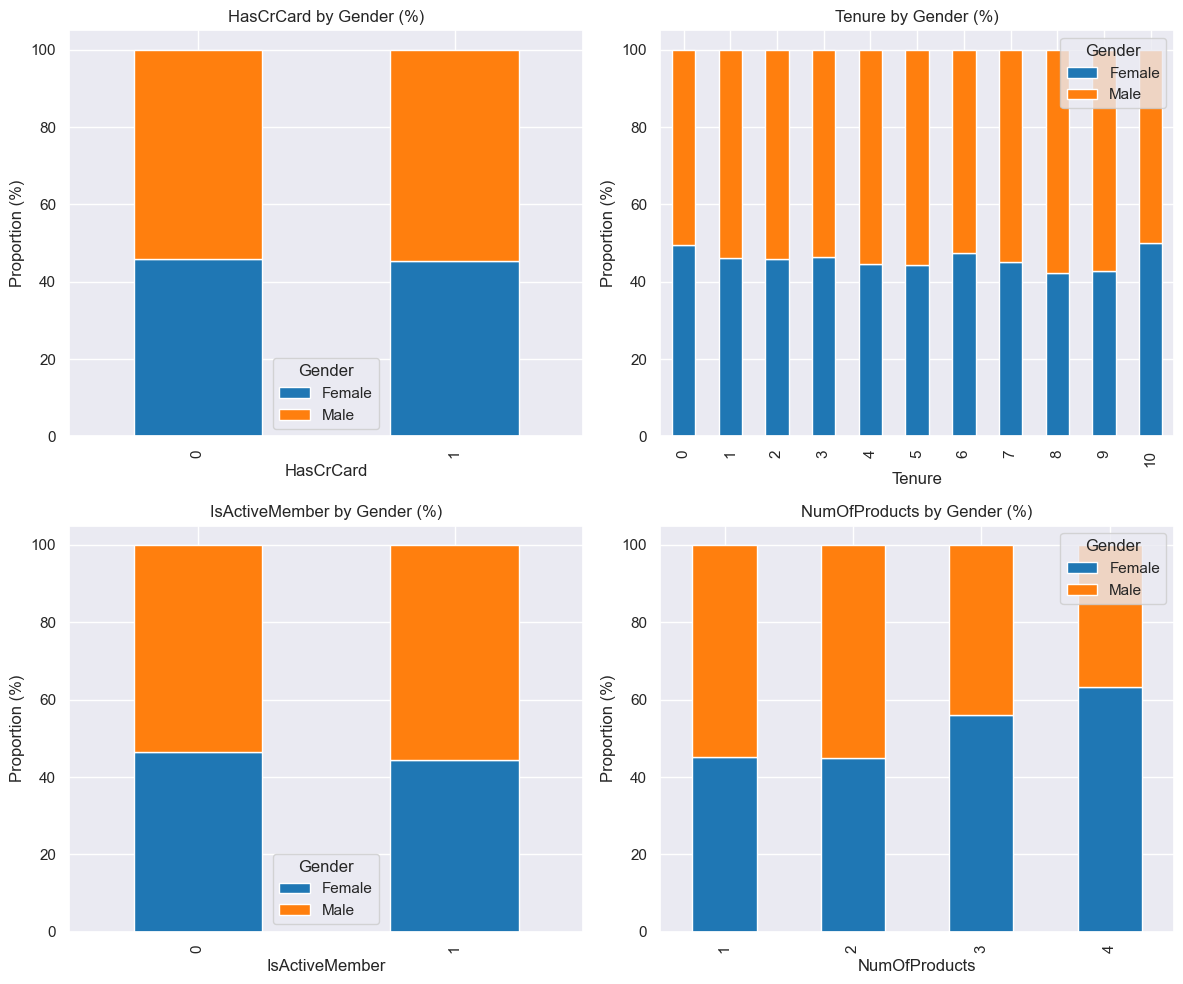

In [24]:
# Interacting gender with, "HasCrCard", "Tenure", "IsActiveMember", "NumOfProducts"
variables_to_interact = ['HasCrCard', 'Tenure', 'IsActiveMember', 'NumOfProducts']

# Create subplots
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, var in enumerate(variables_to_interact):
    # Calculate proportions
    crosstab = pd.crosstab(df[var], df['Gender'], normalize='index').sort_index() * 100
    
    # Plot each stacked barcan you  chart
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], color=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'{var} by Gender (%)')
    axes[i].set_ylabel('Proportion (%)')
    axes[i].legend(title='Gender')

# Adjust layout for readability
plt.tight_layout()
plt.show()

Gender differences don't explain having or not having a credit card.
We can see women appear more likely than men to buy more than two products.\nHowever, again, we have to be careful when comparing because there are very few people buying products 3 and 4.
There are no significant gender differences in activity.
There doesn't seem to be any relation between tenure and gender.
Gender differences don't explain having or not having a credit card, tenure, and recent activity. We can see women appear more likely than men to buy more than two products. However, we discard this evidence as the amount of peopple buying 3 and 4 in general is significantly smaller than those buying products 1 and 2 and we do not think comparison in trends to be appropriate.

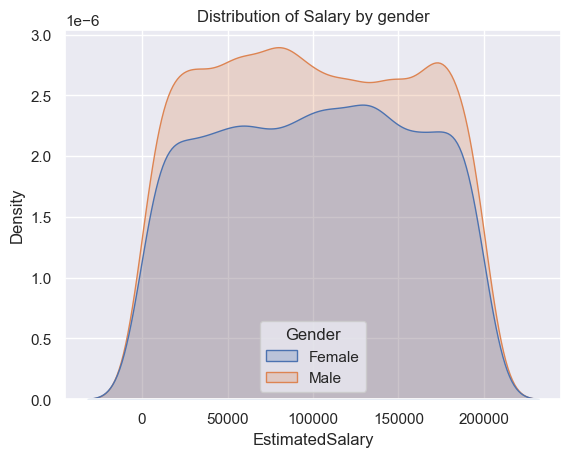

In [25]:
# Interaction between Gender and Estimated Salary 

plot_density(df, "EstimatedSalary", hue_col="Gender", title="Distribution of Salary by gender")

We can see that on average, the estimated salary is lower for women. We also observe differences in the distribution, as the number of men being at around 175k is higher than those being around 130k, whereas for women its the conrtrary. There are less women at the rich end of the distribution with respects to men. 

We now want to observe whether this difference affect other financial variables such as balance or credit score.

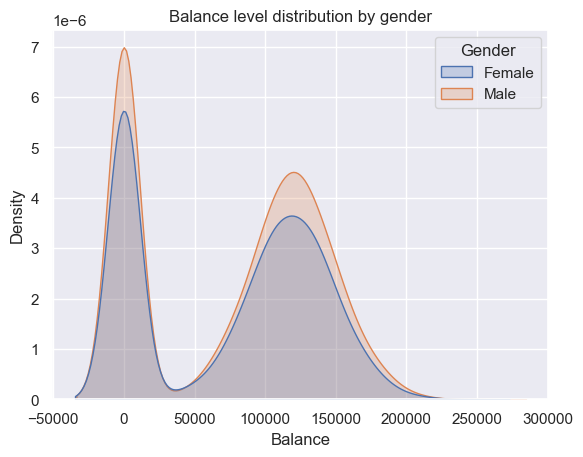

In [26]:
# Interaction between Gender and Balance level

plot_density(df, "Balance", hue_col="Gender", title="Balance level distribution by gender")

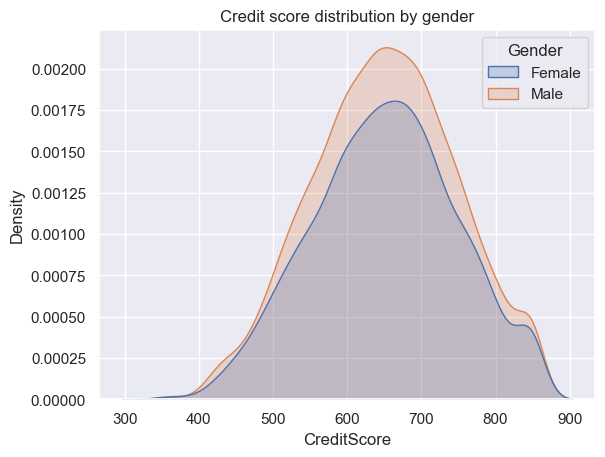

In [27]:
# Interaction between Gender and Credit Score 

plot_density(df, "CreditScore", hue_col="Gender", title="Credit score distribution by gender")

We do not actually observe gender differences in balance or credit score distribution. This coïncides with our previous results of finding no trend linking estimated salary to balance among bank customers.

### Salary Patterns 

Can estimated salary tell us something about activity patters?

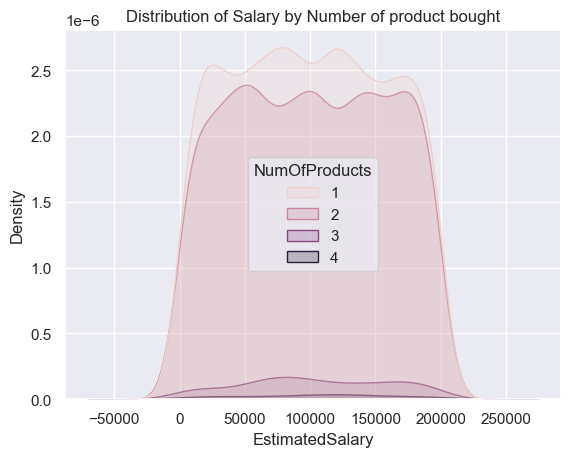

In [28]:
# Can the estimated salary tell us something about the number of product bought ? 

plot_density(df, "EstimatedSalary", hue_col="NumOfProducts", title="Distribution of Salary by Number of product bought")

No trend sticks out. Again, we could question whether it is even interesting to look at number of products due to the small samples for products 3 and 4.

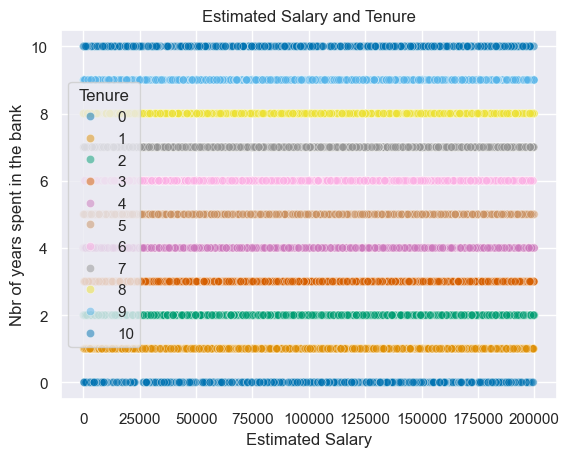

<Figure size 640x480 with 0 Axes>

In [29]:
    # Estimated salary and number of years spent in the bank 

sns.scatterplot(df, 
             x='EstimatedSalary', 
             y='Tenure', 
             hue = 'Tenure',
             palette= sns.color_palette("colorblind", 11),
             alpha=0.5) 
plt.xlabel('Estimated Salary') 
plt.ylabel('Nbr of years spent in the bank') 
plt.title('Estimated Salary and Tenure') 
plt.show()
plt.tight_layout() 

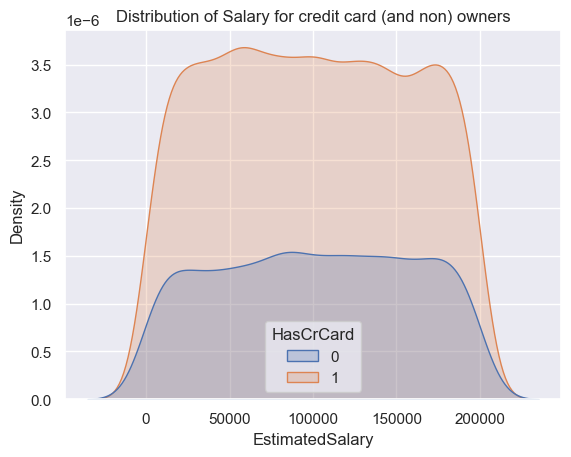

In [30]:
    # Estimated salary and Credit card

plot_density(df, "EstimatedSalary", hue_col="HasCrCard", title="Distribution of Salary for credit card (and non) owners")

No trends stick out.

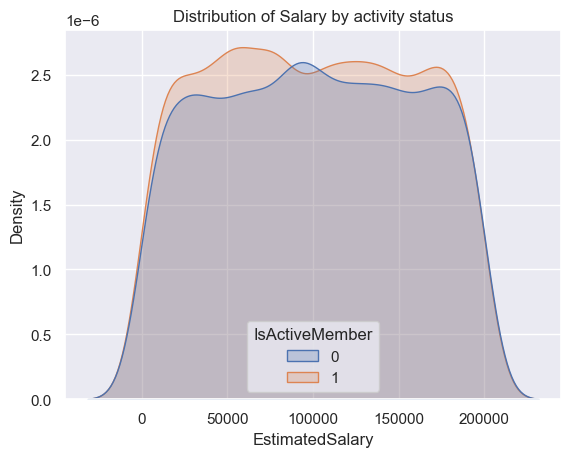

In [31]:
    # Estimated salary and Activity

plot_density(df, "EstimatedSalary", hue_col="IsActiveMember", title="Distribution of Salary by activity status")

No trends stick out. We would have imagined a relationship with estimated salary but it doesnt seem to be a predictor of individual activity - There doesn't seem to be any correlation between estimatd salary and acivity patterns.

### Balance Patterns 

Can balance tell us something?

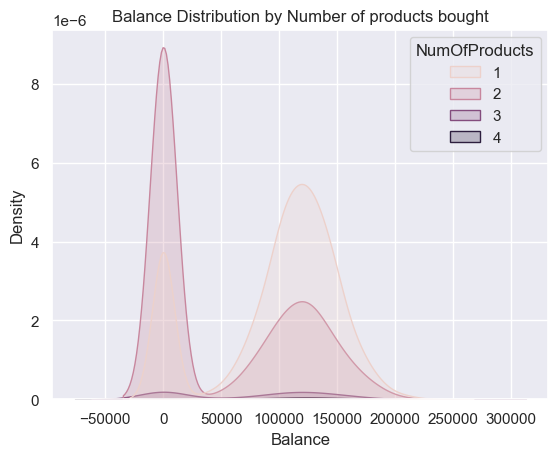

In [32]:
# Can the balance tell us something about the number of products bought ? 

plot_density(df, "Balance", hue_col="NumOfProducts", title="Balance Distribution by Number of products bought")

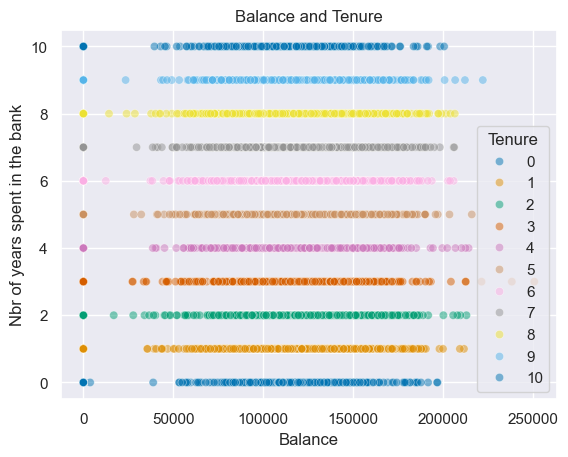

<Figure size 640x480 with 0 Axes>

In [33]:
    # Balance and Tenure 
sns.scatterplot(df, 
             x='Balance', 
             y='Tenure', 
             hue = 'Tenure',
             palette= sns.color_palette("colorblind", 11),
             alpha=0.5) 
plt.xlabel('Balance') 
plt.ylabel('Nbr of years spent in the bank') 
plt.title('Balance and Tenure') 
plt.show()
plt.tight_layout() 

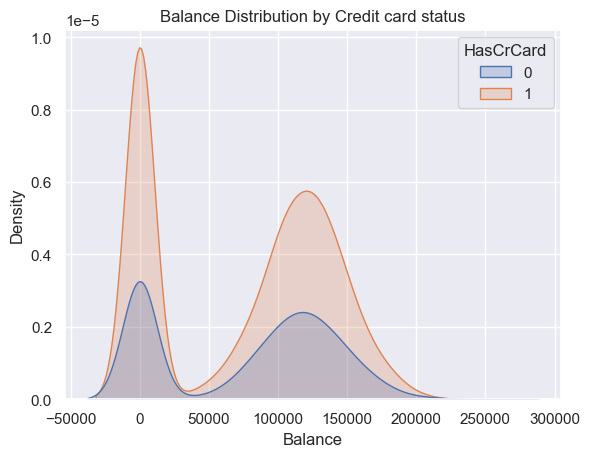

In [34]:
    # Balance and Credit Card owners 

plot_density(df, "Balance", hue_col="HasCrCard", title="Balance Distribution by Credit card status")

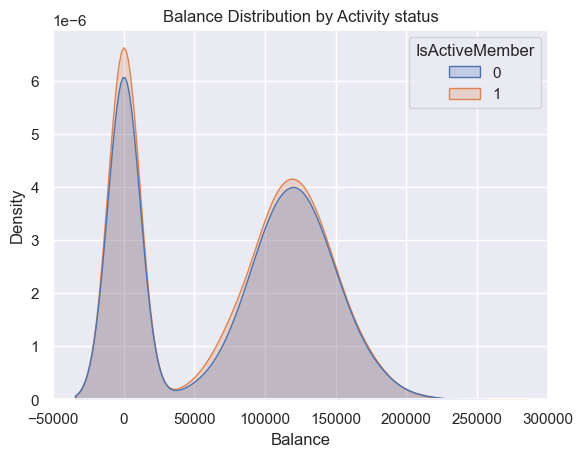

In [35]:
    # Balance and Activity

plot_density(df, "Balance", hue_col="IsActiveMember", title="Balance Distribution by Activity status")

No other trends stick out linking balance and activity variables

### Credit Score Patterns

Can the credit score tell us something about the activity of the customer ? 

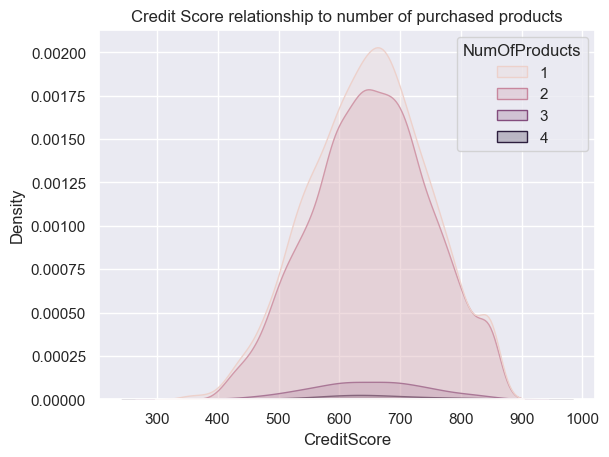

In [36]:
# Can the credit score tell us something about the activity of the customer ? 

    # Credit score and Number of products
plot_density(df, "CreditScore", hue_col="NumOfProducts", title="Credit Score relationship to number of purchased products")

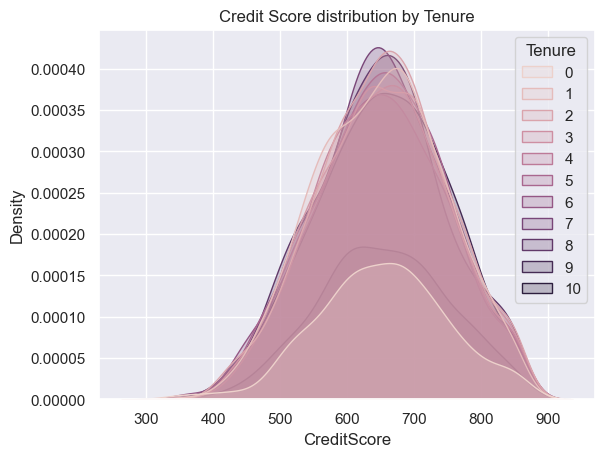

In [37]:
    # Credit Score and Tenure

plot_density(df, "CreditScore", hue_col="Tenure", title="Credit Score distribution by Tenure")

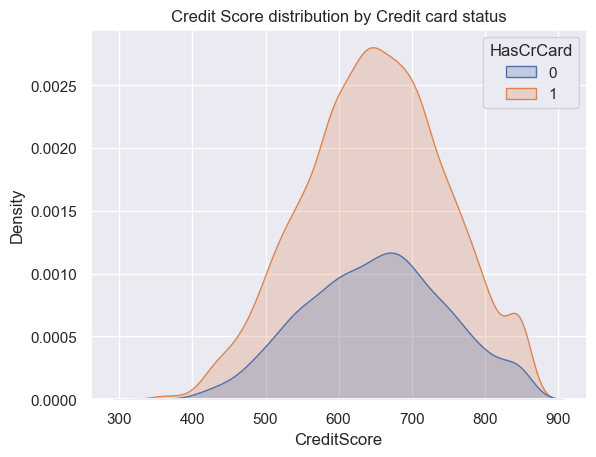

In [38]:
    # Credit Score and Credit card

plot_density(df, "CreditScore", hue_col="HasCrCard", title="Credit Score distribution by Credit card status")

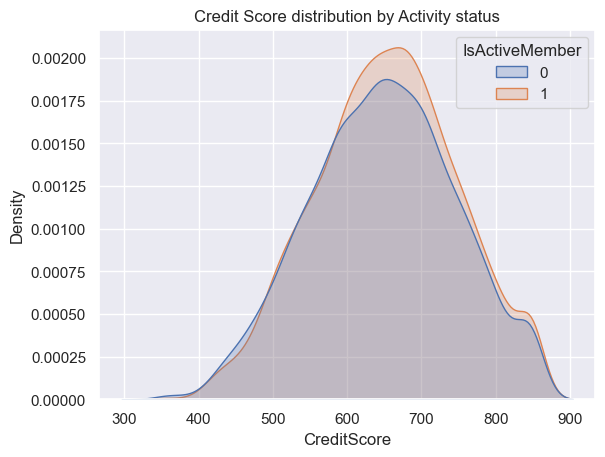

In [39]:
    # Credit Score and Activity 

plot_density(df, "CreditScore", hue_col="IsActiveMember", title="Credit Score distribution by Activity status")

We also do not observe any correlation between the credit score of customers and activity variables .

### Age Patterns

People above 50 seem to be slightly more likely to have a credit card, to be recently active, and to have bought only one product. However, age fails to predict financial variables clearly (see annex).

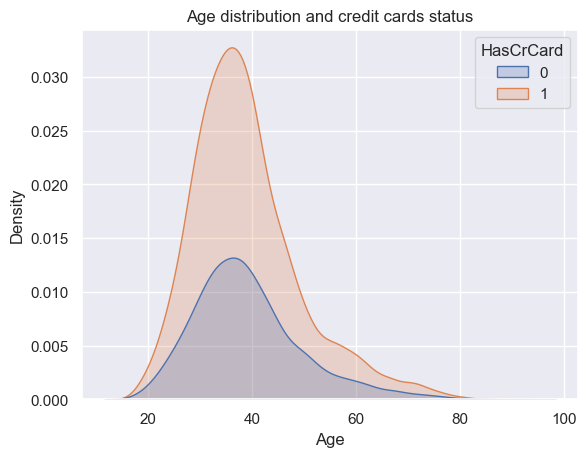

In [40]:
# Age, Credit Card owners 

plot_density(df, "Age", hue_col="HasCrCard", title="Age distribution and credit cards status")

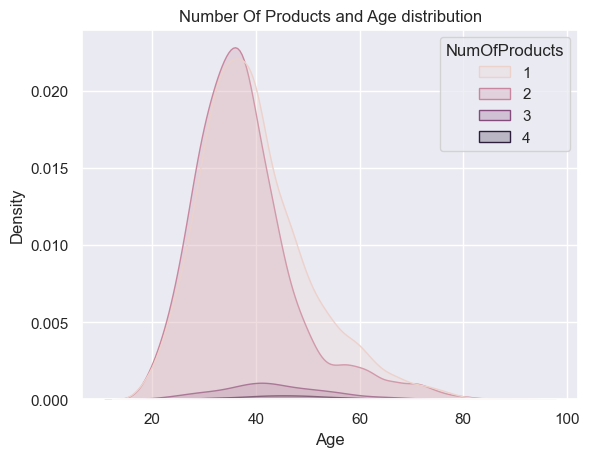

In [41]:
# Age, Number of products bought 

plot_density(df, "Age", hue_col="NumOfProducts", title="Number Of Products and Age distribution")

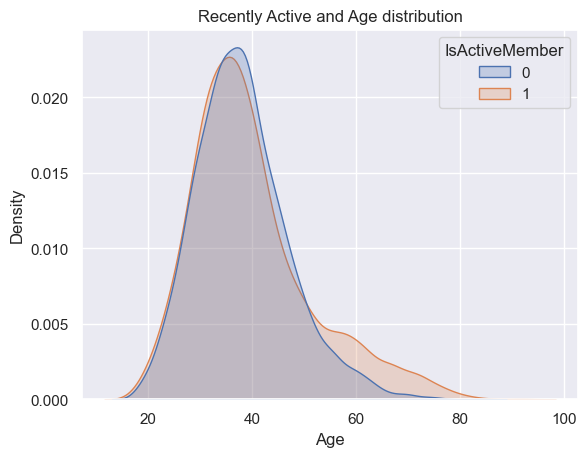

In [42]:
# Age, Number of products bought 

plot_density(df, "Age", hue_col="IsActiveMember", title="Recently Active and Age distribution")

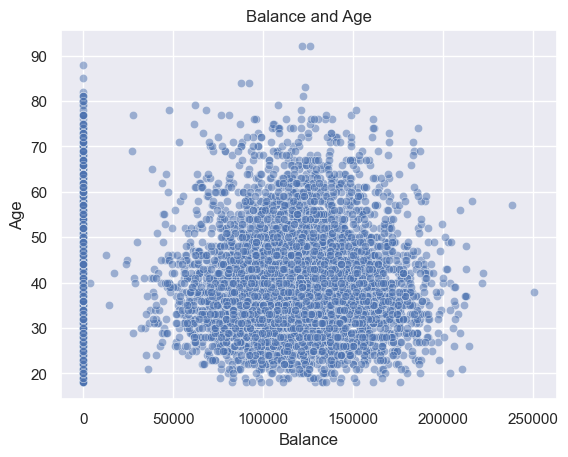

<Figure size 640x480 with 0 Axes>

In [43]:
# Balance and Age
sns.scatterplot(df, 
             x='Balance', 
             y='Age', 
             #palette= sns.color_palette("colorblind", as_cmap=True),
             alpha=0.5) 
plt.xlabel('Balance') 
plt.ylabel('Age') 
plt.title('Balance and Age') 
plt.show()
plt.tight_layout() 

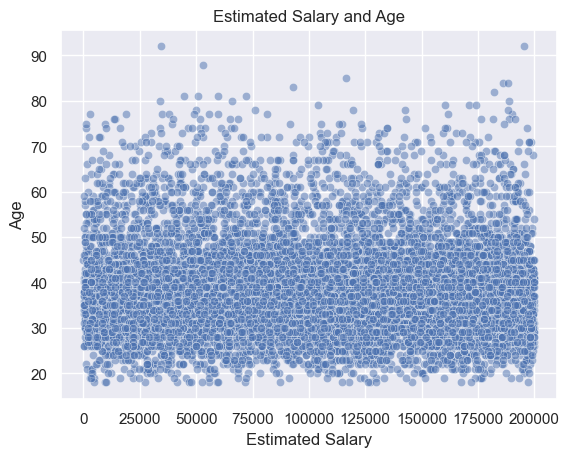

<Figure size 640x480 with 0 Axes>

In [44]:
# Estimated Salary and Age
sns.scatterplot(df, 
             x='EstimatedSalary', 
             y='Age', 
             #palette= sns.color_palette("colorblind", as_cmap=True),
             alpha=0.5) 
plt.xlabel('Estimated Salary') 
plt.ylabel('Age') 
plt.title('Estimated Salary and Age') 
plt.show()
plt.tight_layout() 

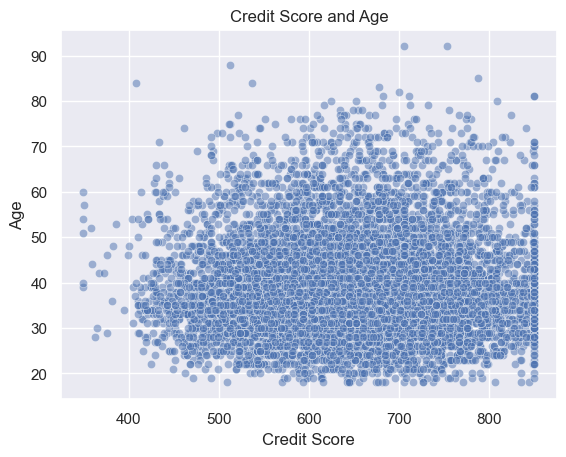

<Figure size 640x480 with 0 Axes>

In [45]:
# Credit Score and Age
sns.scatterplot(df, 
             x='CreditScore', 
             y='Age', 
             #palette= sns.color_palette("colorblind", as_cmap=True),
             alpha=0.5) 
plt.xlabel('Credit Score') 
plt.ylabel('Age') 
plt.title('Credit Score and Age') 
plt.show()
plt.tight_layout() 

### Geographic trends: How is Germany an exception? 

Although we do not observe any trends in geography with restpects to credit card, number of products,  or credit score (see Annex), one striking result that we observe is that german customers do not have the same balance distribution as the other countries. Germany's distribution is solely centered near its peak at around 125000 and doesn't have any values revolving around zero. 
We will thus proceed to focus on how german customers relate to churn rates and focus on finding an explanation. 

One reason for this could eventually be a difference in german institutions and a system of aid and social protection different to that of the other countries. However, we do not find the hypothesis of this gap being due to cultural differences convincing enough to explain the drastic difference in monetary values and the lifestyle dfferences they imply. 

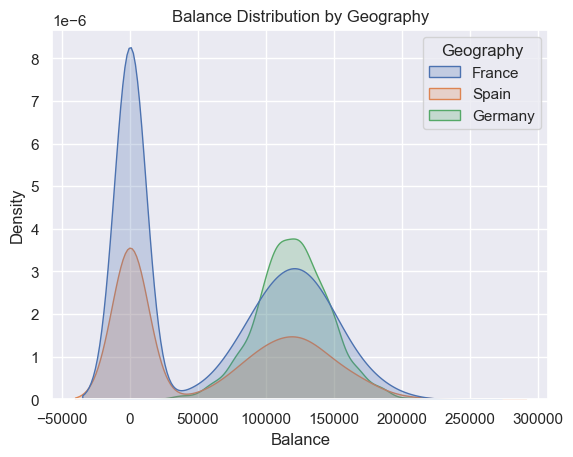

In [46]:
# How does Balance interact with Geography 

plot_density(df, "Balance", hue_col="Geography", title="Balance Distribution by Geography")

Germany doesn't seem to have low balances

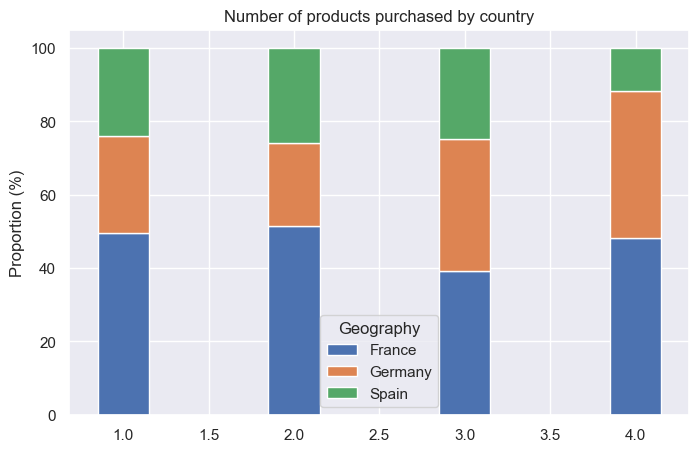

In [47]:
# Number of products, Geography

plot_stacked_bar(df, "NumOfProducts", "Geography", "Number of products purchased by country", normalize=True)

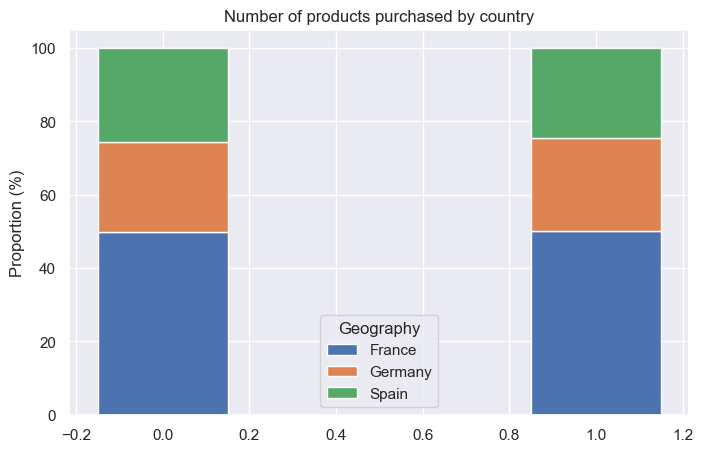

In [48]:
# Has credit card, Geography

plot_stacked_bar(df, "HasCrCard", "Geography", "Number of products purchased by country", normalize=True)


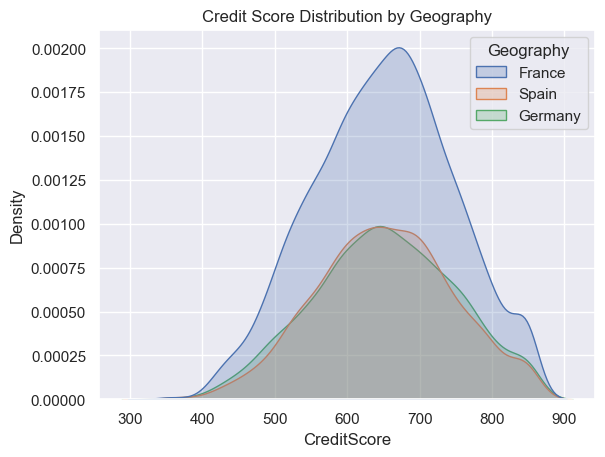

In [49]:
# Credit score and geography

plot_density(df, "CreditScore", hue_col="Geography", title="Credit Score Distribution by Geography")

### EXITED 

This is our main variable of interest, which we will be studying and trying to predict. It is a binary variable that takes two values: 0 and 1 if that person has exited the bank. For the continuation of our analysis we will use the words 'Stayed' and 'Exited'. 

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


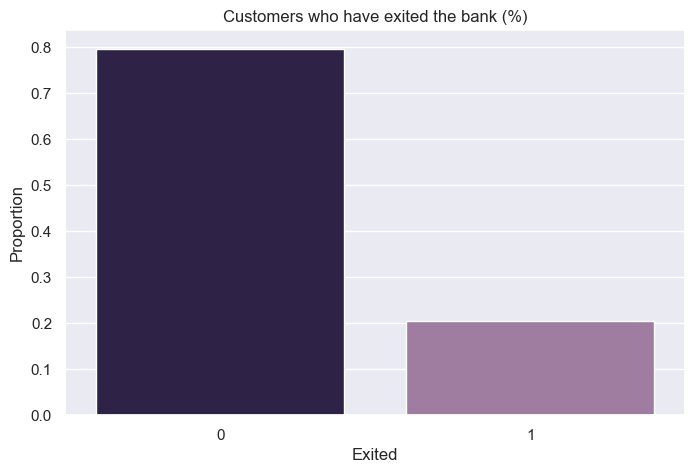

In [50]:
# EXITED 

plot_bar_single(
    df=df,
    category_col="Exited",
    title="Customers who have exited the bank (%)",
    colors=["#2c1c4d", "#a577a6"], 
    normalize=True
)

Around 20 percent of customers have exited the bank. This is  a high number which the bank wishes to reduce.

# Key factors driving customer churn 

### CUSTOMER PROFILE 

### Age

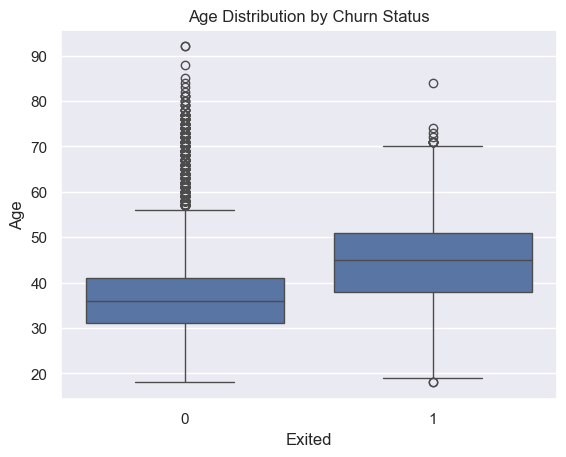

<Figure size 640x480 with 0 Axes>

In [51]:
# How does Age interactw with churn ? 

sns.boxplot(x='Exited', y='Age', data=df) 
plt.title('Age Distribution by Churn Status') 
plt.show()
plt.tight_layout() 


Older customers appear more likely to exit and thos who exit are generally younger, with a more concentrated age range, suggesting that the bank may be more successful in retaining younger clients.
We see that non-exited customers are generally younger, with a more concentrated age range around 30-40 years old, which could come from the fact that, as we showed previously, the dataset is composed mainly of younger customers. However, on the side of the exited customers there's seems to be a pattern with older customers that appear more likely to exit the bank.


/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/3027893153.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_age = df.groupby('Age_group')['Exited'].mean()


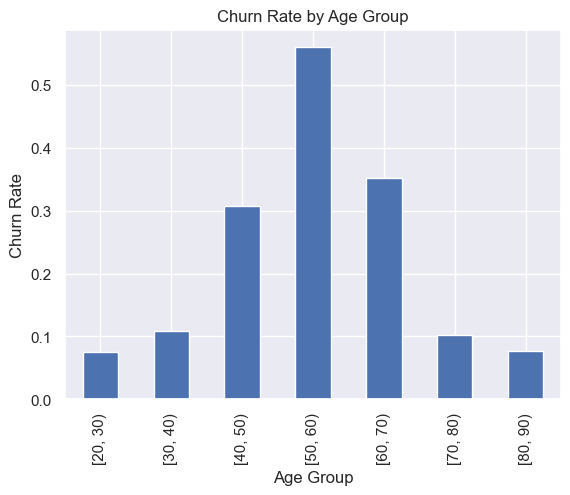

In [52]:
# Creating age groups (e.g., bin ages into 10-year intervals)

df['Age_group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90], right=False) 
# Calculate churn rate per age group 
churn_rate_by_age = df.groupby('Age_group')['Exited'].mean() 
churn_rate_by_age.plot(kind='bar') 
plt.title('Churn Rate by Age Group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Age Group') 
plt.show()


We indeed see that the churn rate is the highest for the age group [50;60] years old. This suggest that the bank may be more successful in retaining/attracting younger clients.

### Geography 

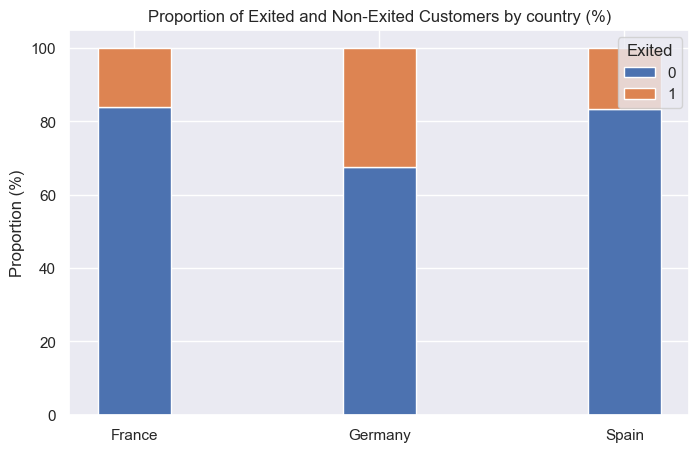

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(


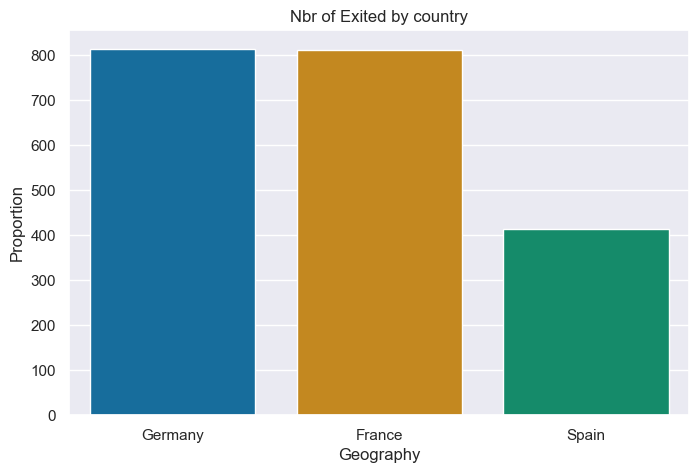

In [53]:
# How does Geography interacts with churn ? 
    # in relative terms, relative comparison : 

plot_stacked_bar(df, "Geography", "Exited", "Proportion of Exited and Non-Exited Customers by country (%)", normalize=True)
    # in absolute count, total number of customers who exited : 

plot_bar_single(dfExited, category_col="Geography", title="Nbr of Exited by country", colors="colorblind")

First chart: gives a relative comparison WITHIN each country. within germany the proportion of customers exiting is higher relative to the total population 
Keeping in mind (as showed in the ANNEX) that in absolute we see that the same number of customers exit the bank in France and Germany. 
Given that germany has acomparable number of customers than spain, and twice less customer than france it might be interesting to further look at what might explain the bigger proportion of churning in this country. 

The relatively strong correlation we found in the correlation matrix between geography and exited might be explained by the significant difference in percentage of exit in Germany. 


### Gender

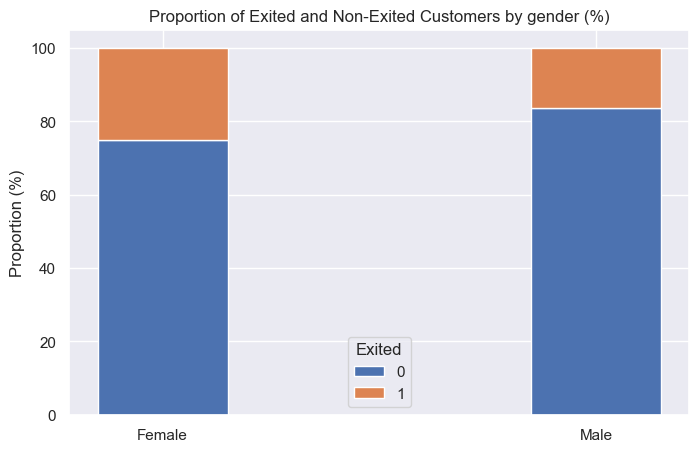

In [54]:
# What about gender ? 

plot_stacked_bar(df, "Gender", "Exited", "Proportion of Exited and Non-Exited Customers by gender (%)", normalize=True)


The percentage of female leaving the bank seem higher overall than for male. If we split by country we see the same results: in all the three countries the percentage of female churning over the full sample of churned customers per country, is always higher (see. table below)

In [55]:
# simple summing and percentages
female_df = df[(df['Gender'] == "Female") & (df['Exited'] == 1)].groupby('Geography')['Gender'].count()
male_df = df[(df['Gender'] == "Male") & (df['Exited'] == 1)].groupby('Geography')['Gender'].count()

agg_gender = pd.merge(female_df, male_df, on='Geography', how='inner') 
agg_gender = agg_gender.rename(columns={"Gender_x": "Nbr Female Churning", "Gender_y": "Nbr Male Churning"})

tot_churning = df[df['Exited'] == 1].groupby('Geography')['Gender'].count()
agg_gender["Tot_churning"] = tot_churning

agg_gender["Female Churning (%)"] = (agg_gender['Nbr Female Churning']/ agg_gender['Tot_churning']) * 100
agg_gender["Male Churning (%)"] = (agg_gender['Nbr Male Churning']/ agg_gender['Tot_churning']) * 100
agg_gender = agg_gender.drop(columns=['Tot_churning'])

agg_gender

,Nbr Female Churning,Nbr Male Churning,Female Churning (%),Male Churning (%)
Geography,,,,
France,460,350,56.790123,43.209877
Germany,448,366,55.036855,44.963145
Spain,231,182,55.932203,44.067797


### FINANCIAL ANALYSIS 

### Balance

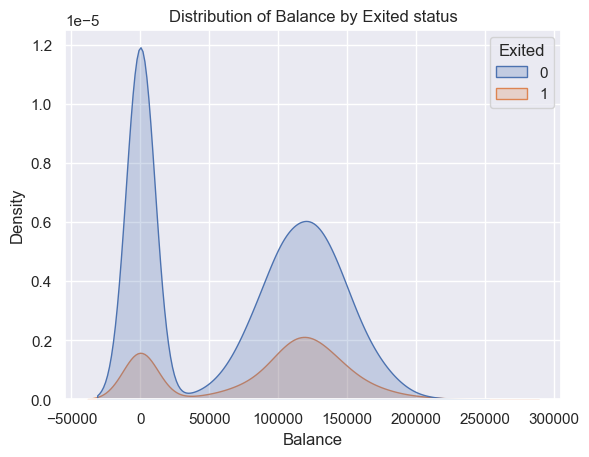

In [56]:
# How does Balance interact with Churning ? 

plot_density(df, "Balance", hue_col="Exited", title="Distribution of Balance by Exited status")


If we suppose an effect of the Balance Status on the probability to churn, we should then see a relatively high pic of the "Exited = 1" distribution curve at a given (or mulitple) inverval of Balance. Which we do not see. We clearly see however that an important proportion of cutsomers not exiting the bank have a balance of 0. 
We then analyse the results at the country level. 

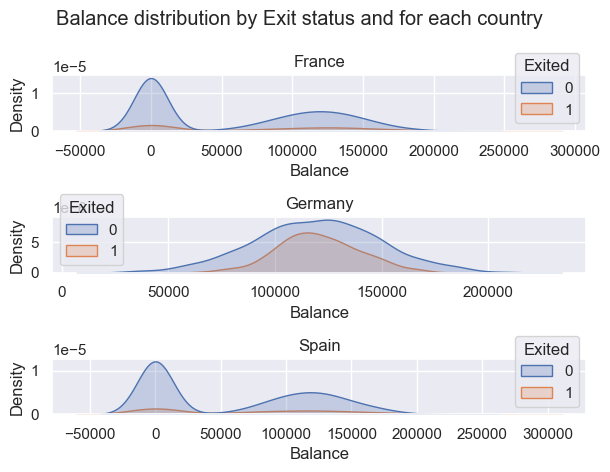

In [57]:
# Quick look how does Balance interact with churn by country
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df_plot = df[df["Geography"] == country]

    sns.kdeplot(data=df_plot, x="Balance", hue="Exited", fill=True, ax=ax[i]) 

fig.suptitle('Balance distribution by Exit status and for each country')
fig.tight_layout()
plt.show()


What we see at the country level is similar to what we conclude with the previous chart: having a small or big balance doesn't seem to really affect your possible future churning. - Mentionner que Germany has no customers with a null balance si sofia ne l'a pas déjà mentionné dans part 1. 

### Estimated Salary 

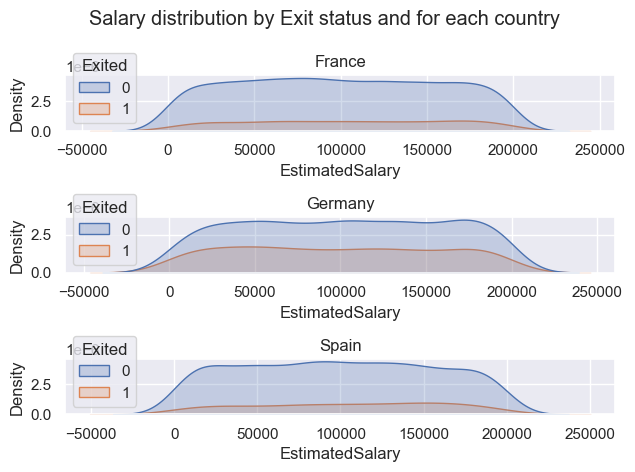

<Figure size 640x480 with 0 Axes>

In [58]:
# How does Salary interacts with churn at the country level? 

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df_plot = df[df["Geography"] == country]

    sns.kdeplot(data=df_plot, x="EstimatedSalary", hue="Exited", fill=True, ax=ax[i]) 
    
sns.set_theme(style="darkgrid")
fig.suptitle('Salary distribution by Exit status and for each country')
fig.tight_layout()
plt.show()
plt.tight_layout() 


Uniform distribution. Nothing to highlight

### Credit score

We now focus on analyzing credit scores. 
Credit scores provide an interesting view of a customer's financial behavior and reliability, via factors such as payment history, outstanding debts, and credit history length. By examining these scores, we aim to identify potential trends or correlations between credit reliability and customer leaving the bank. In other words, since credit scores often reflect financial stability and borrowing capacity, they may serve as valuable indicators for assessing whether specific financial profiles are more likely to leave the bank. 

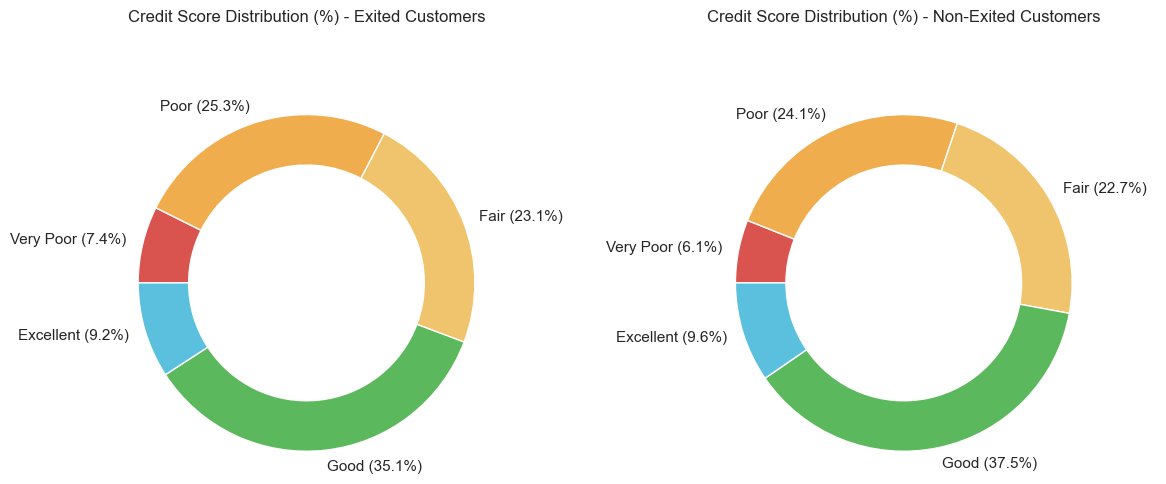

In [59]:
# We first define the Credit score categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

# Define colors and labels
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']

# Subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# For exited customers
df_credit_exit = df.loc[df["Exited"] == 1].copy()
df_credit_exit['Credit_Category'] = df_credit_exit['CreditScore'].apply(categorize)
category_counts_exit = df_credit_exit['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot exited customers pie chart
axes[0].pie(
    category_counts_exit,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_exit)]
)
axes[0].set_title('Credit Score Distribution (%) - Exited Customers')
axes[0].set_xlim([-1.5, 1.5])
axes[0].set_ylim([-1, 1.5])
axes[0].axis('off')

# For non-exited customers
df_credit_non_ex = df.loc[df["Exited"] == 0].copy()
df_credit_non_ex['Credit_Category'] = df_credit_non_ex['CreditScore'].apply(categorize)
category_counts_non_ex = df_credit_non_ex['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot non-exited customers pie chart
axes[1].pie(
    category_counts_non_ex,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_non_ex)]
)
axes[1].set_title('Credit Score Distribution (%) - Non-Exited Customers')
axes[1].set_xlim([-1.5, 1.5])
axes[1].set_ylim([-1, 1.5])
axes[1].axis('off')

# Show plot
plt.tight_layout()
plt.show()

We see a slightly bigger percentage of poor and very poor customers who left the bank but it's not significant.  
Rien quand tu filtres par pays non plus

### ACTIVITY ANALYSIS 

We suppose for the next part of the analysis, and given the previous results, that the bank is 10 years old, very new.  - i still think it's a strong assumption, maybe we just have data for 10 years idk if it's worth making the assumption - 
We therefore look at the effect of spending more or less years in the bank on churning. 

### Years spent in the bank

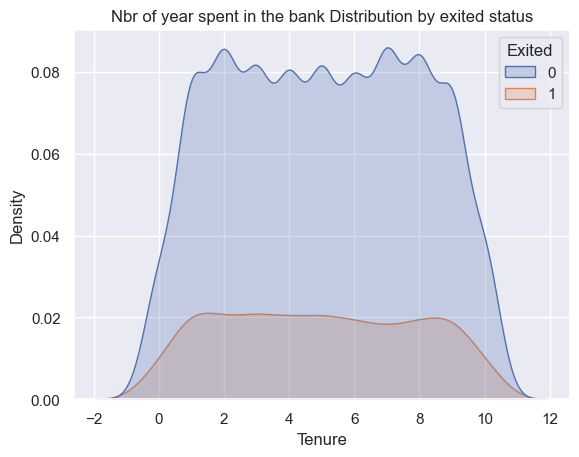

In [60]:
# Does the one who exit the bank spend more or less years in the bank ?

plot_density(df, "Tenure", hue_col="Exited", title="Nbr of year spent in the bank Distribution by exited status")


Distribution is pretty homogeneous. 


### Products bought

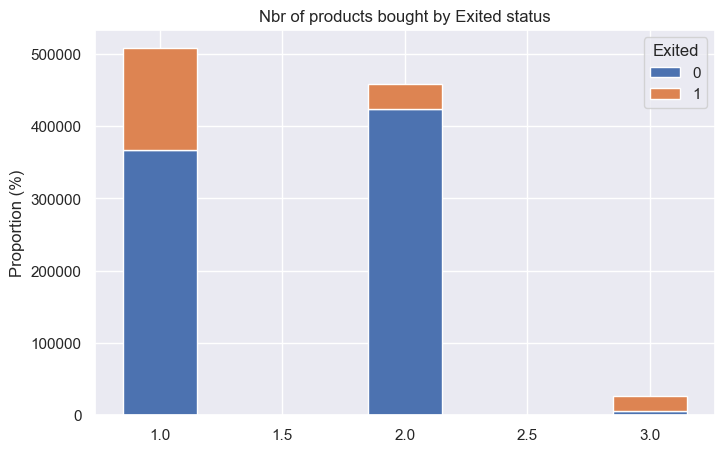

In [61]:
# Proportion of products bought depending on the exit status

plot_stacked_bar(df, "NumOfProducts", "Exited", "Nbr of products bought by Exited status", normalize=False)


In [62]:
df_prod_geo_churn = (df
      .groupby("NumOfProducts")["Exited"]
      .value_counts()
      #.mul()
      .round(2)
      .unstack())
df_prod_geo_churn

Exited,0,1
NumOfProducts,,
1,3675.0,1409.0
2,4242.0,348.0
3,46.0,220.0
4,NaN,60.0


### Activity of customers 

In [63]:
# Simple summing and percentages
country_act_counts = df.groupby('Exited')['IsActiveMember'].value_counts().unstack()
country_act_counts.columns = ['Non-Active Members', 'Recently Active Members']
# country_act_counts

# Calculate the total number of customers per churn status
total = country_act_counts.sum(axis=1)
# total

# Calculate percentages for active and non-active members per churn status
country_act_counts['Recently Active Members (%)'] = (country_act_counts['Recently Active Members'] / total) * 100
country_act_counts['Non-Active Members (%)'] = (country_act_counts['Non-Active Members'] / total) * 100

country_status_percentage = country_act_counts[['Recently Active Members (%)', 'Non-Active Members (%)']]
country_status_percentage

,Recently Active Members (%),Non-Active Members (%)
Exited,,
0,55.456486,44.543514
1,36.082474,63.917526


In [64]:
# Per country split 
# Getting the total members per country for each exit status
country_act_counts_geo = df.groupby(['Geography', 'Exited'])['IsActiveMember'].value_counts().unstack()
country_act_counts_geo.columns = ['Non-Active Members', 'Active Members']
country_act_counts_geo

# Calculate the total number of members per country
country_totals_geo = country_act_counts_geo.sum(axis=1)

# # Calculate percentages for active and non-active members per country
country_act_counts_geo['Active Members (%)'] = (country_act_counts_geo['Active Members'] / country_totals_geo) * 100
country_act_counts_geo['Non-Active Members (%)'] = (country_act_counts_geo['Non-Active Members'] / country_totals_geo) * 100

country_status_percentage_geo = country_act_counts_geo[['Active Members (%)', 'Non-Active Members (%)']]

country_status_percentage_geo

Active Members (%)  Non-Active Members (%)
Geography Exited                                            
France    0                54.543292               45.456708
          1                36.790123               63.209877
Germany   0                56.165192               43.834808
          1                36.363636               63.636364
Spain     0                56.734496               43.265504
          1                34.140436               65.859564

In each country, a notable trend is visible: members who exited tend to have a higher percentage of non-active status compared to those who remained, indicating that inactivity may be a significant factor contributing to churn. For instance, in France, 63.21% of members who exited were not recently active. Similar trends are observed in Germany and Spain, suggesting that non-active status might be a key predictor of churning across different countries in our dataset. - however, given that our table is not a time serie we can also not really judge of the direct effect. Meaning, it could be that the cutsomer is in "not recently active" because he left the bank a while ago. We don't know if the customer was not active EVEN BEFORE he left the bank. 

### Credit Card Owner

/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_50808/819168651.py:91: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(


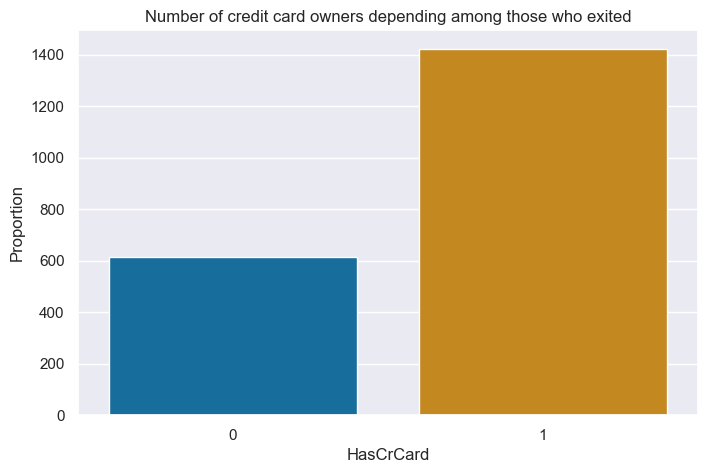

In [65]:
# Proportion of credit card owners depending on the exit status

plot_bar_single(dfExited, "HasCrCard", title="Number of credit card owners depending among those who exited", colors="colorblind")